# 1. Подготовка данных

In [89]:
pip install catboost

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid', {'grid.color': '.9', 'text.color': '.1'})
sns.set_style('darkgrid')

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import timeit

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1. Ознакомление с данными

In [6]:
gold_recovery_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/gold_recovery/gold_recovery_train.csv')
gold_recovery_test =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/gold_recovery/gold_recovery_test.csv')
gold_recovery_full =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/gold_recovery/gold_recovery_full.csv')

In [7]:
# Функция для вывода свойств датафрэйма
def df_info(df):
    #display(df.describe())
    display(df.head(5))
    df.info()
    print()
    print('Кол-во дубликатов = ', df.duplicated().sum())    

In [8]:
df_info(gold_recovery_train)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646,6.733907,2.353017,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,...,20.050975,86.843261,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [9]:
df_info(gold_recovery_test)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [10]:
df_info(gold_recovery_full)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646,6.733907,2.353017,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,...,20.050975,86.843261,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


По предварительному взгляду на датасеты видно:
- в большинстве столбцов есть пропуски. Пока их не трогаем
- тип данных для даты указан не верно. Заменяем его

In [11]:
gold_recovery_train['date'] = gold_recovery_train['date'].astype('datetime64')
gold_recovery_test['date'] = gold_recovery_test['date'].astype('datetime64')
gold_recovery_full['date'] = gold_recovery_full['date'].astype('datetime64')

## 1.2. Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery по известной формуле. Найдем MAE между нашими расчётами и значением признака.

Выведем значения признака rougher.output.recovery

In [12]:
rec_real = gold_recovery_train['rougher.output.recovery']
rec_real

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 16860, dtype: float64

Зададим функцию для расчета величину rougher.output.recovery по формуле из условия задачи

In [13]:
def recovery(C,F,T):
    return (C * (F-T))/(F*(C-T))*100

Вычисляем rougher.output.recovery по формуле

In [14]:
rec_calc = recovery(gold_recovery_train['rougher.output.concentrate_au'],
        gold_recovery_train['rougher.input.feed_au'],
        gold_recovery_train['rougher.output.tail_au'])
rec_calc

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 16860, dtype: float64

На первый взгляд метрики совпадают, но стоит проверить MAE. D рассматриваемых столбцах есть пропуски, поэтому будем рассчитывать MAE для значений без пропусков. 

In [15]:
# Получаем индексы значений без пропусков
good_indexes = rec_real[~rec_real.isna()].index
good_indexes

# Считаем MAE 
MAE(rec_calc[good_indexes], rec_real[good_indexes])

9.444891926100695e-15

MAE практически равно 0, значит признау rougher.output.recovery в таблице вычислен правильно

## 1.3. Проанализируем признаки, недоступные в тестовой выборке.  
Выведем список признаков, которые есть в обучающей, но отсутствуют в тестовой выборке

In [16]:
features_test = set(gold_recovery_test.columns.unique())
features_train = set(gold_recovery_train.columns.unique())
features_hidden = features_train - features_test
features_hidden

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Видим, что в тестовой выборке нам не доступны параметры с индексом OUTPUT -  признаки выходных продуктов по каждому этапу очистки включая параметры финального концетнтрата и хвоста.  Также недоступны расчетные CALCULATION характеристики процесса.   Данные величины невозможно получить/измерить во время выполнения технологического процесса.

## 1.4. Предобработка данных.

### 1.4.1 Предобработка таблицы gold_recovery_train  
В датасете есть пропуски, попробуем их заполнить  
#### 1.4.1.1 Заполнение пропусков целевых признаков  
У нас есть формула для расчета целевого признака по другим признакам.  Для заполнения таких пропусков необходимо:
  - чтобы не было пропусков в признаках, которые подставляются в формулу
  - чтобы в знаменателе формулы не получился ноль.  
  

In [17]:
# Зададим список условий для получения среза данных, которые удувлетворяют условиям выше
condition_1 = (
                    # пропуск в целевом признаке
                    gold_recovery_train['rougher.output.recovery'].isna() &
                   # НЕ пропуск в признаках для расчета
                   ~gold_recovery_train['rougher.output.concentrate_au'].isna() &
                   ~gold_recovery_train['rougher.input.feed_au'].isna() &
                   ~gold_recovery_train['rougher.output.tail_au'].isna() &
                   # знаменатель в формуле != 0
                   (gold_recovery_train['rougher.input.feed_au'] != 0) &
                   (gold_recovery_train['rougher.output.tail_au'] != 
                   gold_recovery_train['rougher.output.concentrate_au']))     

# Делаем срез  
gold_recovery_train.loc[condition_1, ['rougher.output.recovery', 'rougher.output.concentrate_au',
                       'rougher.input.feed_au','rougher.output.tail_au']]

,rougher.output.recovery,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
53,NaN,3.507147,7.548341,2.187465
372,NaN,4.642559,0.139652,2.574309
377,NaN,15.084039,3.501578,5.964024
560,NaN,19.619751,1.921101,1.939904
700,NaN,1.483835,0.253075,1.477470
...,...,...,...,...
16697,NaN,6.038533,11.035269,1.343570
16698,NaN,10.712677,10.943209,1.858404
16699,NaN,0.010000,10.149224,1.729189
16700,NaN,0.010000,10.591710,1.481931


Обнаружили 260 пропусков целевого признака rougher.output.recover, которые можем заполнить по формуле.  Сделаем это

In [18]:
gold_recovery_train.loc[condition_1, 'rougher.output.recovery'] = recovery(
    gold_recovery_train[condition_1]['rougher.output.concentrate_au'], 
    gold_recovery_train[condition_1]['rougher.input.feed_au'], 
    gold_recovery_train[condition_1]['rougher.output.tail_au']
                                                                          )

In [19]:
# Проверяем, что пропуски заполнились:
gold_recovery_train.loc[condition_1, 'rougher.output.recovery'].isna().sum()

0

## Повторим аналогичную операцию для заполнения второго целевого признака  final.output.recovery

In [20]:
# Зададим список условий для получения среза данных
condition_2 = ( # пропуск в целевом признаке
                    gold_recovery_train['final.output.recovery'].isna() &
                   # НЕ пропуск в признаках для расчета
                   ~gold_recovery_train['final.output.concentrate_au'].isna() &
                   ~gold_recovery_train['primary_cleaner.output.concentrate_au'].isna() &
                   ~gold_recovery_train['final.output.tail_au'].isna() &
                   # знаменатель в формуле != 0
                   (gold_recovery_train['primary_cleaner.output.concentrate_au'] != 0) &
                   (gold_recovery_train['final.output.tail_au'] != 
                   gold_recovery_train['final.output.concentrate_au'])) 

# Делаем срез
gold_recovery_train.loc[condition_2, ['final.output.recovery', 'final.output.concentrate_au',
                       'primary_cleaner.output.concentrate_au','final.output.tail_au']]  

,final.output.recovery,final.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.tail_au
49,NaN,43.389252,35.865996,3.202483
372,NaN,4.304974,5.184108,0.164934
375,NaN,23.704807,6.476057,3.942216
377,NaN,36.597453,15.797071,7.723369
433,NaN,35.686803,31.446601,6.693746
...,...,...,...,...
16800,NaN,40.001769,32.851533,1.831268
16801,NaN,38.769032,41.368745,2.465185
16802,NaN,32.852508,41.319246,3.214806
16803,NaN,37.019149,42.824945,2.431493


Обнаружили 245 пропусков целевого признака final.output.recovery, которые можем заполнить по формуле. Сделаем это 

In [21]:
gold_recovery_train.loc[condition_2, 'final.output.recovery'] = recovery(
    gold_recovery_train.loc[condition_2, 'final.output.concentrate_au'],
    gold_recovery_train.loc[condition_2,'primary_cleaner.output.concentrate_au'],
    gold_recovery_train.loc[condition_2,'final.output.tail_au']
                                                                        )

In [22]:
#Проверяем, что пропуски заполнились:
gold_recovery_train.loc[condition_2,'final.output.recovery'].isna().sum()

0

Еще раз посмотрим на наличие пропусков в целевых признаках

In [23]:
display(gold_recovery_train[gold_recovery_train['rougher.output.recovery'].isna() |
                   gold_recovery_train['final.output.recovery'].isna()].shape)

display(gold_recovery_train.shape)

(2372, 87)

(16860, 87)

Все равно остались пропуски.  Поскольку это целевые признаки, то очень рискованно заполнять их средними/медианами/модами - можем сильно потерять в точности модели.  
Пропусков не очень много (15%) и при их удалении останется достаточно много данных - принимаем решение удалить оставшиеся пропуски

In [24]:
gold_recovery_train = gold_recovery_train[
        ~gold_recovery_train['rougher.output.recovery'].isna() &
        ~gold_recovery_train['final.output.recovery'].isna()] 

#### 1.4.1.2 Заполнение пропусков оставшихся признаков X (не целевых)

В датасете есть пропуски почти в каждом столбце.  Посмотрим сколько останется строк, если удалить все строки с пропусками:

In [25]:
display(gold_recovery_train.shape)
display(gold_recovery_train.dropna().shape)

(14488, 87)

(11188, 87)

При удалении пропусков теряем около 23% данных.  Это довольно много. Попробуем их заполнить  
Посмотрим в каких столбцах больше всего пропусков

In [26]:
pd.options.display.max_rows = 200
display(gold_recovery_train.isna().sum().sort_values(ascending=False))
pd.options.display.max_rows = 10

secondary_cleaner.output.tail_sol                     1675
rougher.state.floatbank10_e_air                        466
rougher.input.floatbank11_xanthate                     449
primary_cleaner.output.concentrate_sol                 337
final.output.concentrate_sol                           229
secondary_cleaner.state.floatbank2_a_air               221
rougher.input.feed_size                                145
rougher.input.feed_pb                                  127
primary_cleaner.output.concentrate_pb                  118
final.output.tail_pb                                   117
primary_cleaner.input.xanthate                         106
rougher.input.feed_sol                                  97
primary_cleaner.output.tail_sol                         71
rougher.input.floatbank11_sulfate                       44
rougher.output.concentrate_sol                          41
rougher.input.floatbank10_sulfate                       39
primary_cleaner.input.depressant                        

Text(0, 0.5, 'Количество пропусков')

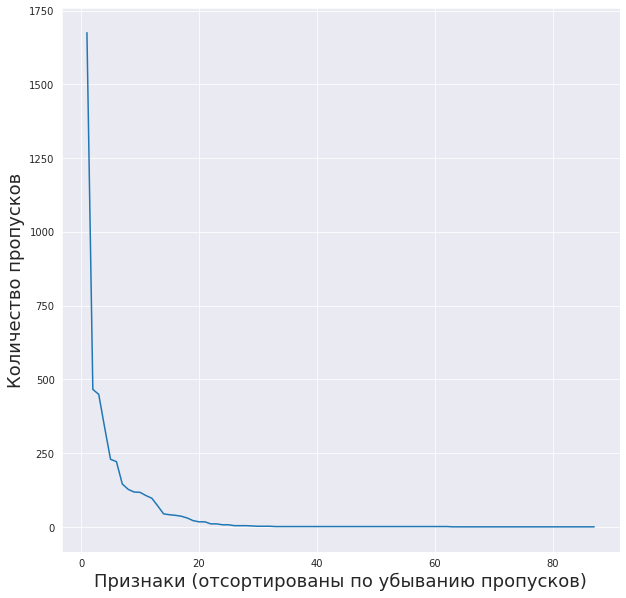

In [27]:
# Также покажем на графике

plt.figure(figsize = (10,10))
plt.plot([i for i in range(1, len(gold_recovery_train.isna().sum().sort_values(ascending=False))+1)], 
         gold_recovery_train.isna().sum().sort_values(ascending=False))
plt.xlabel('Признаки (отсортированы по убыванию пропусков)', fontsize=18)
plt.ylabel('Количество пропусков', fontsize=18)

Видим, что основная часть пропусков собрана в нескольких столбцах.   Установим лимит количества пропусков. Если в столбце пропусков больше этого лимита - работаем со столбцом и заполняем пропуски, если меньше лимита - удаляем пропуски 

In [28]:
limit_of_drops = 20

Выделим список столбцов, которые превышают лимит по пропускам

In [29]:
train_columns_with_nan = list(gold_recovery_train.isna().sum().sort_values(ascending=False)[ 
            gold_recovery_train.isna().sum().sort_values(ascending=False) > limit_of_drops].index)
train_columns_with_nan

['secondary_cleaner.output.tail_sol',
 'rougher.state.floatbank10_e_air',
 'rougher.input.floatbank11_xanthate',
 'primary_cleaner.output.concentrate_sol',
 'final.output.concentrate_sol',
 'secondary_cleaner.state.floatbank2_a_air',
 'rougher.input.feed_size',
 'rougher.input.feed_pb',
 'primary_cleaner.output.concentrate_pb',
 'final.output.tail_pb',
 'primary_cleaner.input.xanthate',
 'rougher.input.feed_sol',
 'primary_cleaner.output.tail_sol',
 'rougher.input.floatbank11_sulfate',
 'rougher.output.concentrate_sol',
 'rougher.input.floatbank10_sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.sulfate',
 'secondary_cleaner.state.floatbank2_b_air']

Посмотрим на гистограммы отобранных признаков из рассматриваемого датасета gold_recovery_train

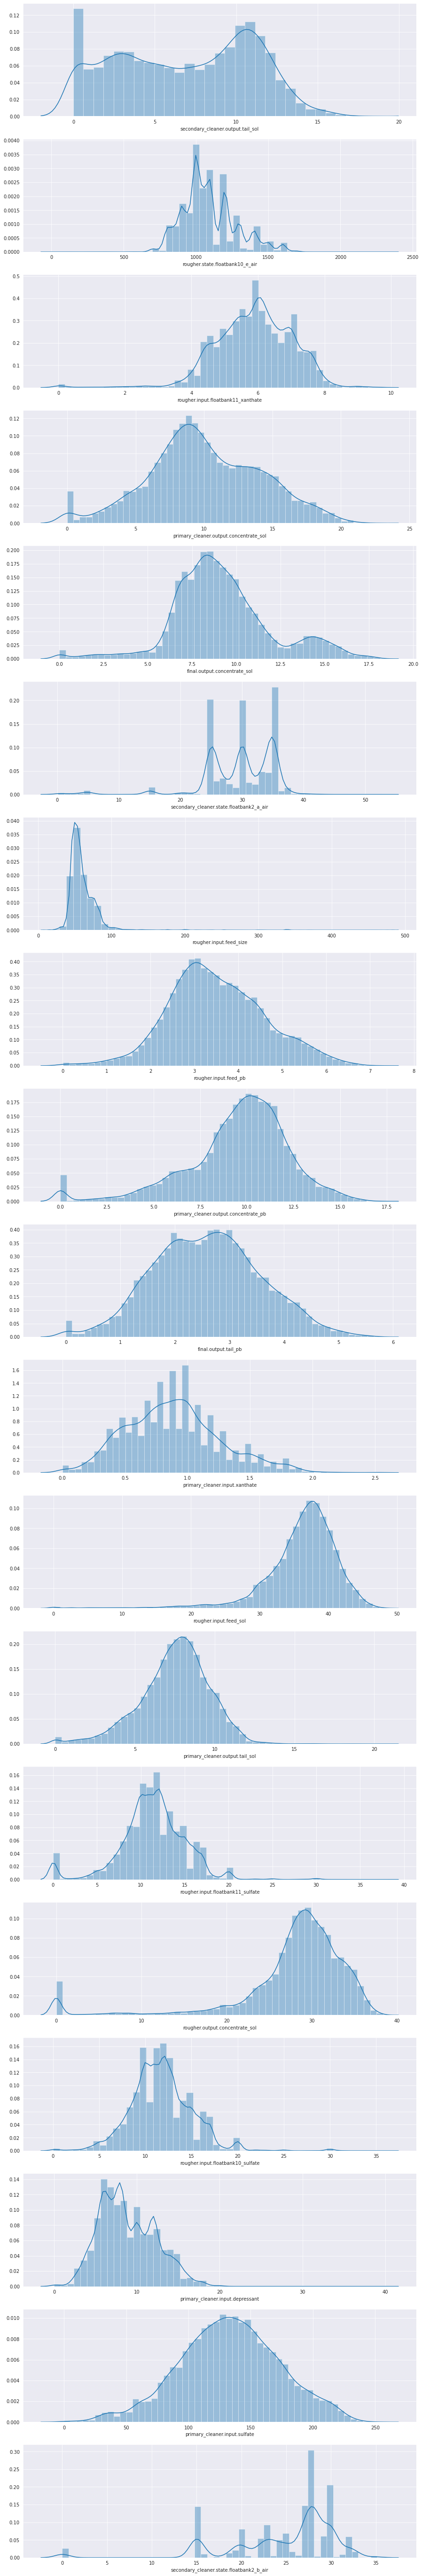

In [30]:
fig, ax = plt.subplots(len(train_columns_with_nan),1, figsize=(15,100))
i = 0
for col in train_columns_with_nan:
    sns.distplot(gold_recovery_train[col], ax=ax[i])
    i += 1

### По гистограммам видим:
1. Гистограммы "secondary_cleaner.output.tail_sol" (№1) и "secondary_cleaner.state.floatbank2_a_air (№6)" имеют нестандартное распределение.  Их нежелательно заполнять средними/медианами/модами. Необходим другой способ.
2. Все остальные гистограммы похожи на нормальное распределение, поэтому их можно заполнить медианами.
3. У некоторых гистограмм есть скачки в нуле - это выбросы. Ими займемся позже в слежующих пунктах

### Заполнение пропусков "secondary_cleaner.output.tail_sol"  
Посмотрим как коррелирует данный признак с остальными на тепловой карте

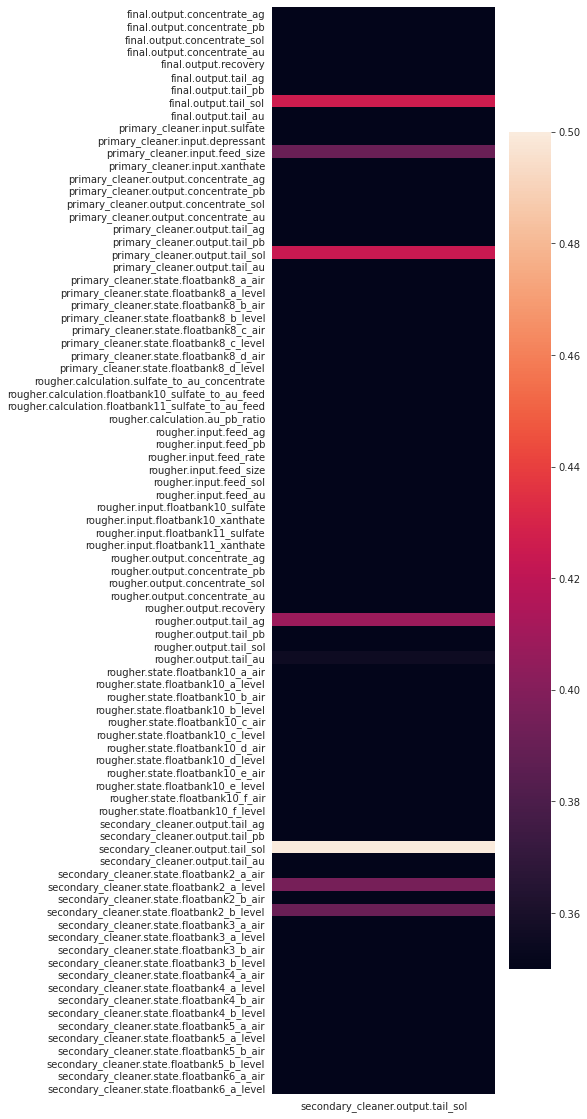

In [31]:
plt.figure(figsize=(5,20))
sns.heatmap(gold_recovery_train.corr()['secondary_cleaner.output.tail_sol'].to_frame(),
           vmin=0.35, vmax=0.5)

На тепловой карте увидели, что искомый признак неплохо коррелирует с 5 другими признаками.  Для дальнейшей работы отберем 3 из них с наибольшей корреляцией (самый ярий цвет)

In [32]:
corr_features_1 = ['final.output.tail_sol',
                   'primary_cleaner.output.tail_sol',
                   'rougher.output.tail_ag']

Поскольку имеется хорошая корреляция, то можно заполнить пропуски в  secondary_cleaner.output.tail_sol при помощи линейной регрессии. В данном случае у нас будет обучающая выборка - набор строк датасета, в которых НЕ пропущены значения искомого и коррелирующих признаков.  Тестовой выборкой будет набор строк датасета, в которых ПРОпущены искомые значения (их мы как раз хотим найти), но не пропущены значения коррелирующих признаков.  На обучающей выборке не будем использовать кроссвалидацию, а о качестве модели будем судить в конце по новой построенной гистограмме признака

In [33]:
# импортируем модель
lin_model_1 = LinearRegression()

# Создаем датасет для обучения нашей модели
df_train_1 = gold_recovery_train[
    corr_features_1 + ['secondary_cleaner.output.tail_sol']].dropna()

# выделяем из датасета признаки
xx_train_1 = df_train_1[corr_features_1] 

# выделяем из датасета целевой признак
yy_train_1 = df_train_1['secondary_cleaner.output.tail_sol'] 

# стандартизируем признаки
from sklearn.preprocessing import StandardScaler
xx_train_st_1 = StandardScaler().fit_transform(xx_train_1)

# обучаем модель
lin_model_1.fit(xx_train_st_1, yy_train_1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Теперь создадим условие, чтобы из нашего основного датасета gold_recovery_train сделать срез только тех строк, в которых пропущен наш искомый признак, но есть все остальные коррелирующие признаки для предсказания   

In [34]:
condition_3 = (gold_recovery_train['secondary_cleaner.output.tail_sol'].isna() &
    ~gold_recovery_train['final.output.tail_sol'].isna() &
    ~gold_recovery_train['primary_cleaner.output.tail_sol'].isna() &
    ~gold_recovery_train['rougher.output.tail_ag'].isna())

Теперь можем предсказать пропущенные значения в искомом признаке 

In [35]:
xx_for_predict_1 = gold_recovery_train[condition_3][corr_features_1]
xx_for_predict_st_1 = StandardScaler().fit_transform(xx_for_predict_1)

gold_recovery_train.loc[condition_3, 'secondary_cleaner.output.tail_sol'] = lin_model_1.predict(
    xx_for_predict_st_1)

Проверим сколько осталось пропусков

In [36]:
gold_recovery_train['secondary_cleaner.output.tail_sol'].isna().sum()

60

60 пропусков вместо 1650 - отличный результат!  
  
Теперь посмотрим на гистограмму с заполненными пропусками  

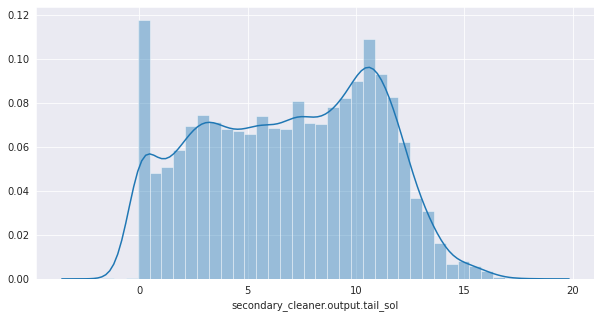

In [37]:
plt.figure(figsize=(10,5))
sns.distplot(gold_recovery_train['secondary_cleaner.output.tail_sol'])

После заполнения гистограмма стала лучше - пропуски равномерно заполнили центральный минимум, форма гистограммы стала ближе к нормальному распределению. С учетом этого выбранный способ заполнения верным

### По аналогии с помощью линейной регрессии заполним столбец "secondary_cleaner.state.floatbank2_a_air"  
Посмотрим как коррелирует данный признак с остальными на тепловой карте

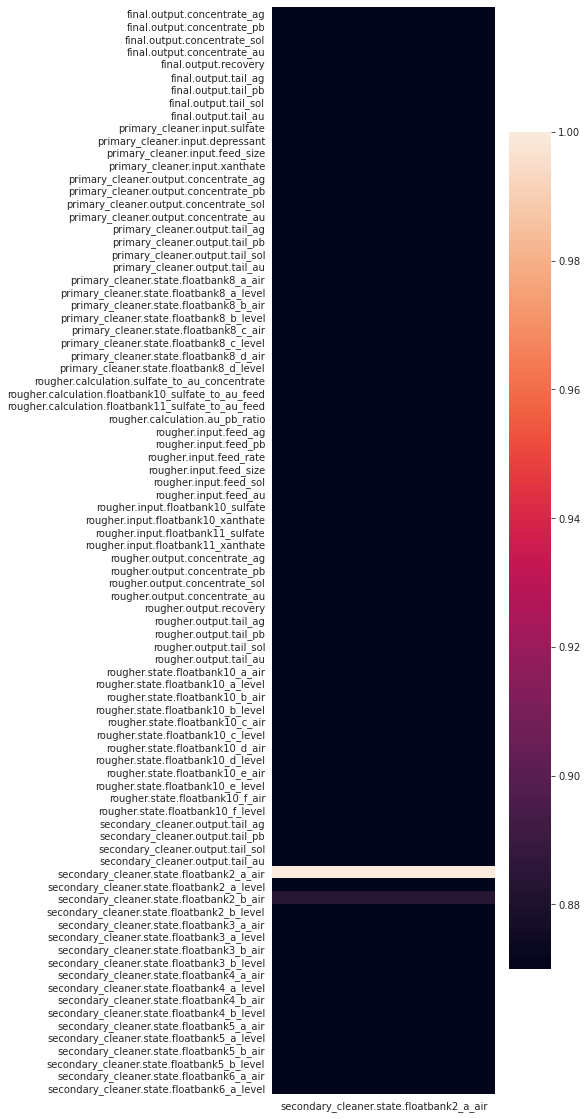

In [38]:
plt.figure(figsize=(5,20))
sns.heatmap(gold_recovery_train.corr()['secondary_cleaner.state.floatbank2_a_air'].to_frame(),
           vmin=0.87, vmax=1.0)

На тепловой карте видим корреляцию выше 87% между secondary_cleaner.state.floatbank2_a_air и secondary_cleaner.state.floatbank2_b_air.  

Для большей наглядности выведем эти 2 признака на отдельном графике

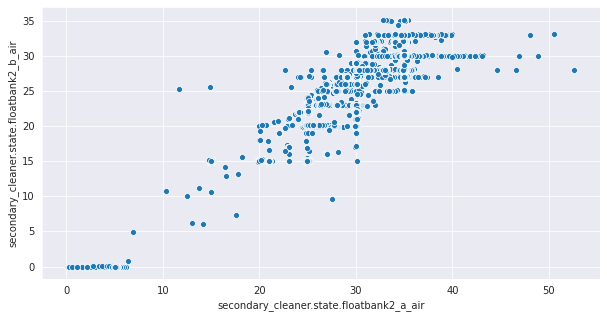

In [39]:
plt.figure(figsize=(10,5))
sns.scatterplot(data= gold_recovery_train, x = 'secondary_cleaner.state.floatbank2_a_air',
               y = 'secondary_cleaner.state.floatbank2_b_air')

Только один данный признак помещаем в набор признаков "X"  нашей модели линейной регрессии

In [40]:
corr_features_2 = ['secondary_cleaner.state.floatbank2_b_air']

По аналогии с предыдущими вычислениями применим модель линейной регрессии. Обучем модель на всей обучающей выборке без учета строк с пропусками в искомом признаке и без кроссвалидации, а затем применим обученную модель для заполнения пропусков (условно тестовая выборка).  О результатах работы модели будем судить по новой гистограмме

In [41]:
# импортируем модель
lin_model_2 = LinearRegression()

# Создаем датасет для обучения нашей модели
df_train_2 = gold_recovery_train[
    corr_features_2 + ['secondary_cleaner.state.floatbank2_a_air']].dropna()

# выделяем из датасета признаки
xx_train_2 = df_train_2[corr_features_2] 

# выделяем из датасета целевой признак
yy_train_2 = df_train_2['secondary_cleaner.state.floatbank2_a_air'] 

# стандартизируем признаки
xx_train_st_2= StandardScaler().fit_transform(xx_train_2)

# обучаем модель
lin_model_2.fit(xx_train_st_2, yy_train_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Теперь создадим условие, чтобы из нашего остновного датасета gold_recovery_train сделать срез только тех строк, в которых пропущен наш искомый признак, но есть все остальные коррелирующие признаки для предсказания   (условно наша тестовая выборка)

In [42]:
condition_4 = (gold_recovery_train['secondary_cleaner.state.floatbank2_a_air'].isna() &
                ~gold_recovery_train['secondary_cleaner.state.floatbank2_b_air'].isna())

Теперь можем предсказать пропущенные значения в нашем искомом признаке 'secondary_cleaner.output.tail_sol'

In [43]:
xx_for_predict_2 = gold_recovery_train[condition_4][corr_features_2]
xx_for_predict_st_2 = StandardScaler().fit_transform(xx_for_predict_2)

gold_recovery_train.loc[
    condition_4, 'secondary_cleaner.state.floatbank2_a_air'] = lin_model_2.predict(xx_for_predict_st_2)

Проверим сколько осталось пропусков

In [44]:
gold_recovery_train['secondary_cleaner.state.floatbank2_a_air'].isna().sum()

6

6 пропусков вместо 221 - хороший результат!  
  
Теперь посмотрим на гистограмму с заполненными пропусками  

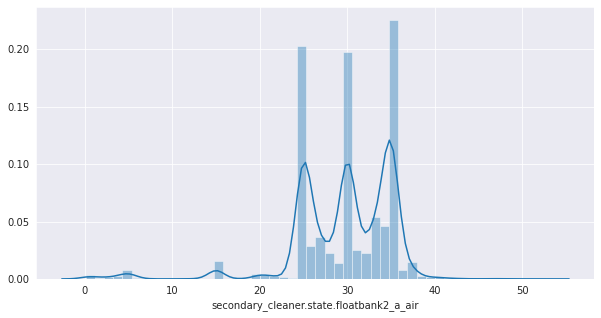

In [45]:
plt.figure(figsize=(10,5))
sns.distplot(gold_recovery_train['secondary_cleaner.state.floatbank2_a_air'])

Визуально картина гистограммы не изменилась.   Значит при заполнении мы не нарушили закон распределения нашег опризнака. С учетом этого принимаем выбранный нами способ заполнения.

### Заполнение оставшихся признаков, у которых число пропусок превышает принятый нами лимит

Как уже писали ранее - оставшиеся признаки имеют нормальное распределение с выбросами, + самих пропусков относительно не так много, также задача по условию напоминает временные ряды. Поэтому можем заполнить пропуски предыдущими во времени значениями (метод 'ffill').    
Удалим из рассматриваемого списка 2 признака, которые заполнили ранее с помощью линейной регрессии 

In [46]:
train_columns_with_nan = list(
    set(train_columns_with_nan) - set(['secondary_cleaner.output.tail_sol', 'secondary_cleaner.state.floatbank2_a_air']))

Выполняем заполнение медианами

In [47]:
gold_recovery_train.loc[:, train_columns_with_nan] =  gold_recovery_train.loc[
                :, train_columns_with_nan].fillna(method = 'ffill')

Посмотрим на гистограммы признаков после заполнения

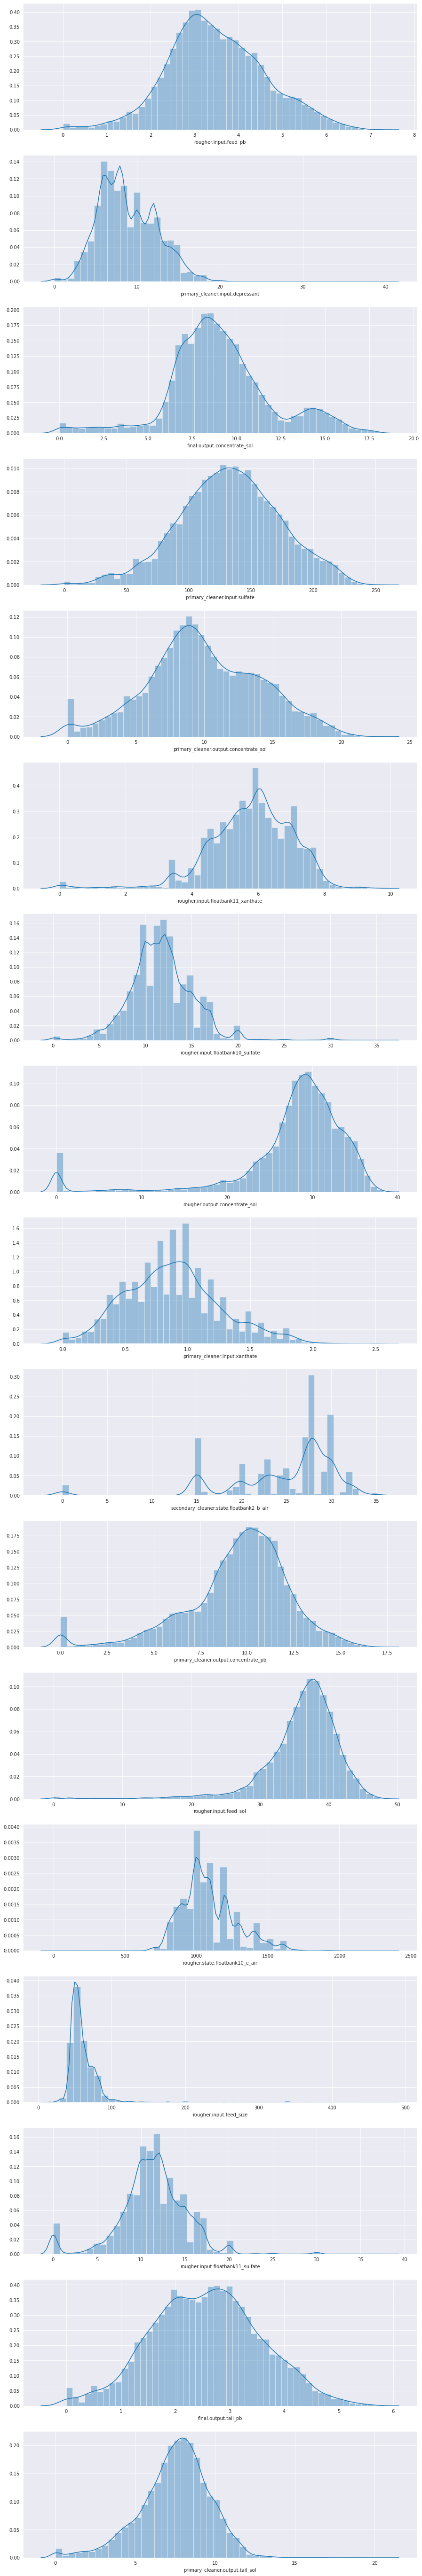

In [48]:
fig, ax = plt.subplots(len(train_columns_with_nan),1, figsize=(15,100))
i = 0
for col in train_columns_with_nan:
    sns.distplot(gold_recovery_train[col], ax=ax[i])
    i += 1

В целом характер гистограмм не изменился.  Принимаем наш способ заполнения.    
Посмотрим на количество пропусков в обучающей выборке теперь

In [49]:
display(gold_recovery_train.shape)
display(gold_recovery_train.dropna().shape)

(14488, 87)

(14350, 87)

Пропусков осталось совсем мало. Можно их удалить

In [50]:
gold_recovery_train = gold_recovery_train.dropna()
gold_recovery_train.shape

(14350, 87)

### Также удаляем все нулевые значения, т.к. судя по гистограммам это выбросы.  
Посмотрим сколько данных мы потеряем

In [51]:
gold_recovery_train[(gold_recovery_train == 0).any(axis=1)].shape

(1239, 87)

Теряем менее 10% данных. Это приемлемо

In [52]:
gold_recovery_train = gold_recovery_train[~(gold_recovery_train == 0).any(axis=1)]
gold_recovery_train.shape

(13111, 87)

### 1.4.2 Предобработка таблицы gold_recovery_test.  
в датасете gold_recovery_test отсутствуют целевые признаки rougher.output.recovery и final.output.recovery.   Данную информацию возьмем из полного датасета gold_recovery_full.

In [53]:
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full[['date', 'rougher.output.recovery','final.output.recovery']],
                        on='date', how='left')

Посмотрим на пропуски

In [54]:
display(gold_recovery_test.shape)
display(gold_recovery_test.dropna().shape)

(5856, 55)

(5229, 55)

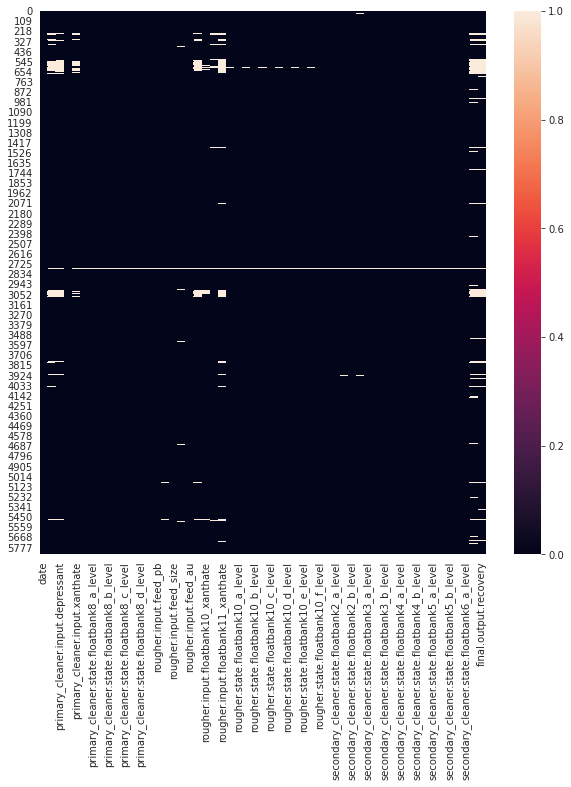

In [55]:
plt.figure(figsize = (10,10))
sns.heatmap(gold_recovery_test.isna())

Удалим все строки, где пропущены целевые признаки.  
Пропуски в остальных признаках заполним методом "ffill"

In [56]:
# Условия для среза без пропусков в целевых признаках
condition_5  =  ~(gold_recovery_test['rougher.output.recovery'].isna() | gold_recovery_test['final.output.recovery'].isna())

# удаляем строки с пропусками в целевом признаке
gold_recovery_test = gold_recovery_test.loc[condition_5]
gold_recovery_test.shape

(5290, 55)

In [57]:
# заполняем пропуски в остальных признаках
gold_recovery_test = gold_recovery_test.fillna(method = 'ffill')

In [58]:
gold_recovery_test.isna().sum().sum()

0

## Общие выводы по п.1   
1. В исходных данных было достаточно много пропусков.  Для заполнения пропусков использовали:
    - аналитическую формулу из условия задачи (расчет recovery).
    - линейную регрессию с использованием коррелирующих признаков
    - заполнение методом 'ffill'
2. Часть пропусков пришлось удалить.  Изначально было 16860 + 5856 = 22716 строк => после удаления стало  13111 + 5229 = 18340

# 2. Исследовательский анализ данных  
(Будем исследовать изначальный датасет gold_recovery_full)

## 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

Создадим отдельные списки с концентрациями на каждом этапе очистки для каждого элемента (3 элемента в каждом списке, соответствующие этапу очистки) и объединим их в один общий список (объединяем 4 списка, соответствующих хим. элементу в руде)

In [59]:
concentrate_ag = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag',
                  'final.output.concentrate_ag']

concentrate_pb = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb',
                  'final.output.concentrate_pb']

concentrate_sol = ['rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol',
                  'final.output.concentrate_sol']

concentrate_au = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au',
                  'final.output.concentrate_au']

concentrate_all = [concentrate_ag, concentrate_pb, concentrate_sol, concentrate_au]

# также создаем список с загаловками для графика
concentrate_titles = ['Концентрация ag на разных этапах очистки',
                      'Концентрация pb на разных этапах очистки',
                      'Концентрация sol на разных этапах очистки',
                      'Концентрация au на разных этапах очистки']

Выведем графики изменения во времени концентраций каждого хим. элемента на разных этапах очистки

In [60]:
fig, ax = plt.subplots(len(concentrate_all),1, figsize=(15,40))

ax_i = 0
for i in range(len(concentrate_all)):
    for j in range(len(concentrate_all[i])):
        #a = sns.scatterplot(data = gold_recovery_full[(gold_recovery_full.T != 0).all()], - вывод без нулевых значений
        a = sns.scatterplot(data = gold_recovery_full,
                 x = 'date', y = concentrate_all[i][j], marker=".", alpha=0.5,
                    label=concentrate_all[i][j], ax = ax[ax_i], linewidth=0.3)
    a.set_xlim(gold_recovery_full['date'][0], gold_recovery_full['date'][len(gold_recovery_full)-1])
    a.set_title(concentrate_titles[i])
    ax_i += 1 

Output hidden; open in https://colab.research.google.com to view.

Выводы:
1. Концентрация ag стабильно снижается после каждого этапа очистки.
2. Графики концентрации pb сильно накладываются друг на друга. Причем для одного и того же этапа в разные временные интервалы происходит как увеличение, так и уменьшение концентрации. В целом можно сказать: 
    - на первичной очистке концентрация незначительно увеличивается;
    - на вторичной очистке концентрация меняется в обе стороны, поэтому можно сказать, что в среднем концентрация не изменяется.
3. Концентрация sol очень сильно снижается на первичной очистке.  На вторичной не меняется (после нее наблюдается в равной степени как рост так и уменьшение коцентрации).
4. Концентрация au увеличивается на каждом этапе очистки

## 2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.  
### 2.2.1 Построим гистограммы этих величин

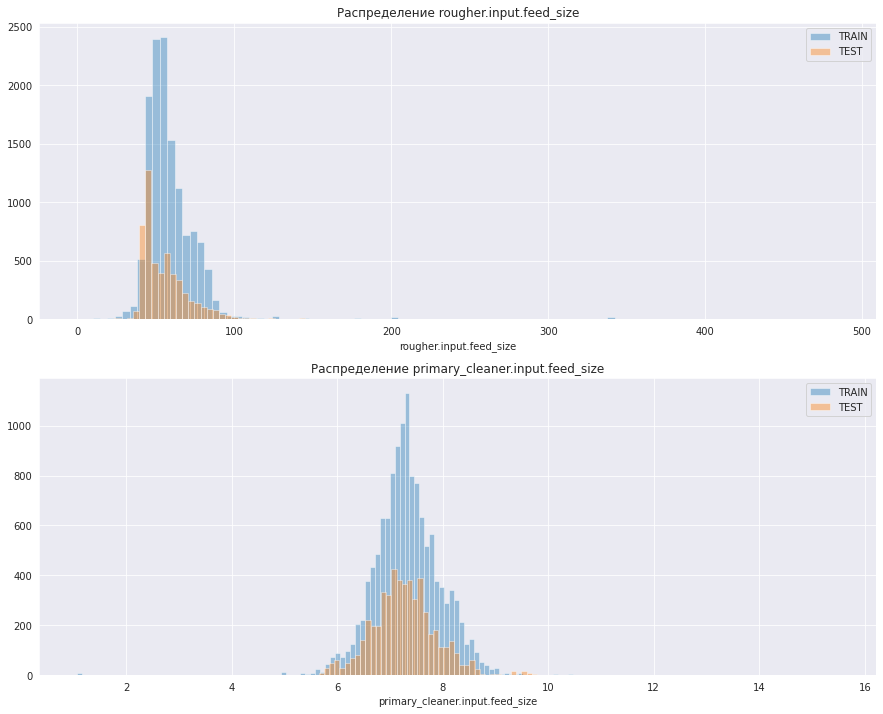

In [61]:
# Столбцы с размерами зерен
feed_sizes = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size', ]

# Заголовки
feed_sizes_titles = ['Распределение rougher.input.feed_size',
                     'Распределение primary_cleaner.input.feed_size']

feed_sizes_legends = ['TRAIN', 'TEST']

fig, ax = plt.subplots(2,1, figsize=(15,12))

for i in range(2):
    a = sns.distplot(gold_recovery_train[feed_sizes[i]], bins=100 , kde=False,
                label = feed_sizes_legends[0], ax=ax[i])
    a = sns.distplot(gold_recovery_test[feed_sizes[i]], bins=100 , kde=False,
                label = feed_sizes_legends[1], ax=ax[i])
    ax[i].legend()
    a.set_title(feed_sizes_titles[i])     

Гистограммы напоминают нормальное распределение и визуально имеют схожее мат. 
ожидание. Есть выбросы. Посмотрим также на медианны:

In [62]:
print(gold_recovery_train['rougher.input.feed_size'].median())
print(gold_recovery_test['rougher.input.feed_size'].median())

55.38753374827981
50.8468431600362


In [63]:
print(gold_recovery_train['primary_cleaner.input.feed_size'].median())
print(gold_recovery_test['primary_cleaner.input.feed_size'].median())

7.289999961853027
7.25


Видим, что средние значения rougher.input.feed_size  ощутимо отличаются, а у primary_cleaner.input.feed_size - практически совпадают.  
Для rougher.input.feed_size стоит сделать аб-тест и проверить - на самом ли деле в выборках отличаются данные значения  
### 2.2.2 АБ тест среднего значения rougher.input.feed_size на TRAIN и TEST выборке  
Поскольку в выборке имеются выбросы - будем использовать метод Манна-Уитни

In [64]:
group_a = gold_recovery_train['rougher.input.feed_size']
group_b = gold_recovery_test['rougher.input.feed_size']

stats.mannwhitneyu(group_a, group_b)

MannwhitneyuResult(statistic=27632909.0, pvalue=8.2229195247214e-104)

АБ тест с использованием критерия Манна-Уитни  дал нам значение p_value почти = 0.   Следовательно можем принять "альтернативную гипотезу" о том, что средние значения в наших группах отличаются.  Тем не менее разница не более 10%, продолжим наше исследование

## 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.  
### 2.3.1 Построим графики данных величин и проанализируем их  


In [65]:
# Создаем столбцы с суммарной концентрацией на каждом этапе
gold_recovery_full['rougher.output.concentrate_total'] = (
            gold_recovery_full[concentrate_ag[0]] + gold_recovery_full[concentrate_pb[0]] + 
            gold_recovery_full[concentrate_sol[0]] + gold_recovery_full[concentrate_au[0]])

gold_recovery_full['primary_cleaner.output.concentrate_total'] = (
            gold_recovery_full[concentrate_ag[1]] + gold_recovery_full[concentrate_pb[1]] + 
            gold_recovery_full[concentrate_sol[1]] + gold_recovery_full[concentrate_au[1]])

gold_recovery_full['final.output.concentrate_total'] = (
            gold_recovery_full[concentrate_ag[2]] + gold_recovery_full[concentrate_pb[2]] + 
            gold_recovery_full[concentrate_sol[2]] + gold_recovery_full[concentrate_au[2]])

Text(0.5, 1.0, 'Суммарная концентрация на разных этапах очистки')

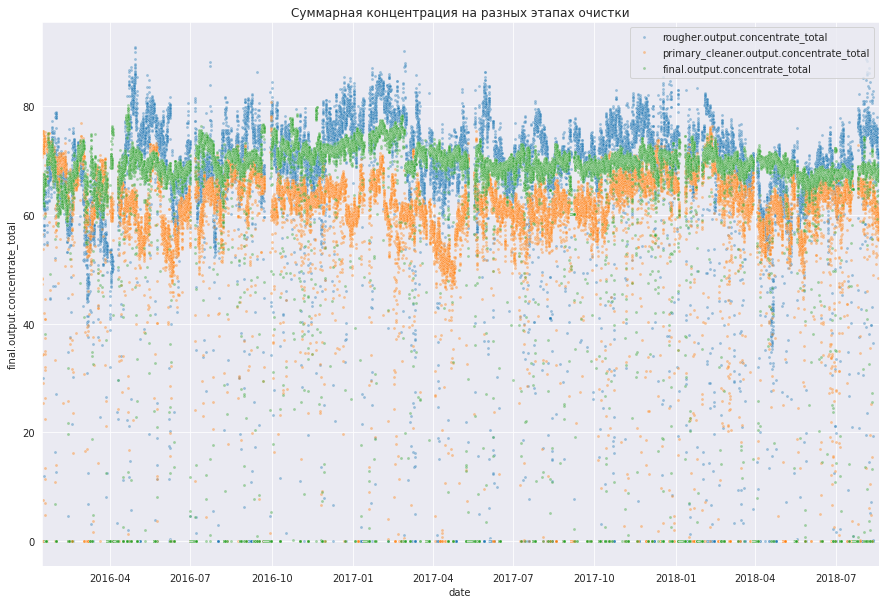

In [66]:
# Строим графики
concentrate_total_all = ['rougher.output.concentrate_total', 
                        'primary_cleaner.output.concentrate_total',
                        'final.output.concentrate_total']


plt.figure(figsize=(15,10))

for i in range(len(concentrate_total_all)):
    a = sns.scatterplot(data = gold_recovery_full,
         x = 'date', y = concentrate_total_all[i],
         marker=".", alpha=0.4, label=concentrate_total_all[i], linewidth=0.3)
a.set_xlim(gold_recovery_full['date'][0], gold_recovery_full['date'][len(gold_recovery_full)-1])
a.set_title('Суммарная концентрация на разных этапах очистки')   

### На графиках видим, что присутствуют нулевые значения - это явно аномалии. Их уже разбирали и удалили на этапе предобработки, когда работали с датасетами gold_recovery_train и gold_recovery_test.  
### Также есть много значений, которые сильно отличаются от среднего. Их также стоит удалить из обучающей выборки для увеличения качества модели. Зададим лимиты признаков, по которым будем считать показания выбросами:

Для величины rougher.output.concentrate_total задаим порог:

In [67]:
conc_limit_rougher = 50

Для наглядности отобразим на графике

(735978.0, 736924.4583217592)

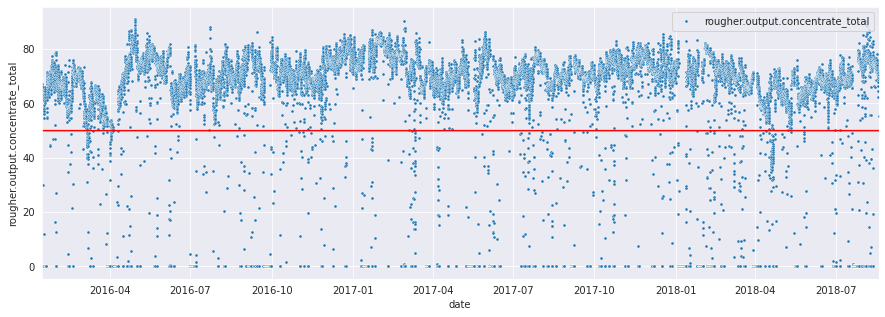

In [68]:
plt.figure(figsize=(15,5))
a = sns.scatterplot(data = gold_recovery_full, x = 'date', y = concentrate_total_all[0],
         marker=".", label=concentrate_total_all[0], linewidth=0.3)

a = sns.lineplot(data= gold_recovery_full, 
            x = gold_recovery_full['date'],
            y = pd.Series([conc_limit_rougher for i in range(len(gold_recovery_full))]),
                 color='red')

a.set_xlim(gold_recovery_full['date'][0], gold_recovery_full['date'][len(gold_recovery_full)-1])

Для величины primary_cleaner.output.concentrate_total зададим порог, равный:

In [69]:
conc_limit_primary_cleaner = 45

для наглядности отобразим на графике

(735978.0, 736924.4583217592)

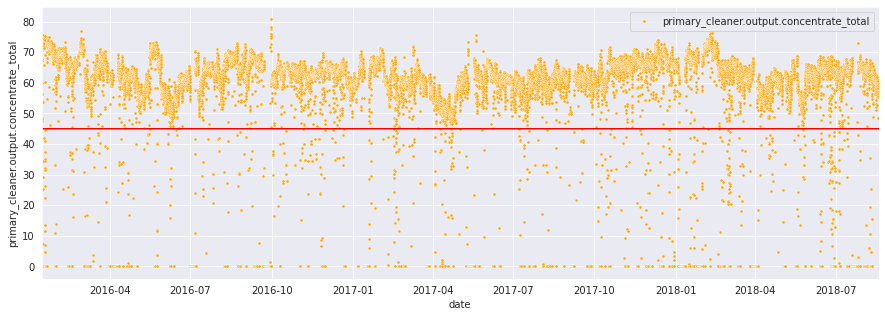

In [70]:
plt.figure(figsize=(15,5))
a = sns.scatterplot(data = gold_recovery_full, x = 'date', y = concentrate_total_all[1],
         marker=".", label=concentrate_total_all[1], linewidth=0.3, color='orange')

a = sns.lineplot(data= gold_recovery_full, 
            x = gold_recovery_full['date'],
            y = pd.Series([conc_limit_primary_cleaner for i in range(len(gold_recovery_full))]),
                 color='red')

a.set_xlim(gold_recovery_full['date'][0], gold_recovery_full['date'][len(gold_recovery_full)-1])

Для величины final.output.concentrate_total зададим порог, равный:

In [71]:
conc_limit_final = 58

И для наглядности отобразим на графике

(735978.0, 736924.4583217592)

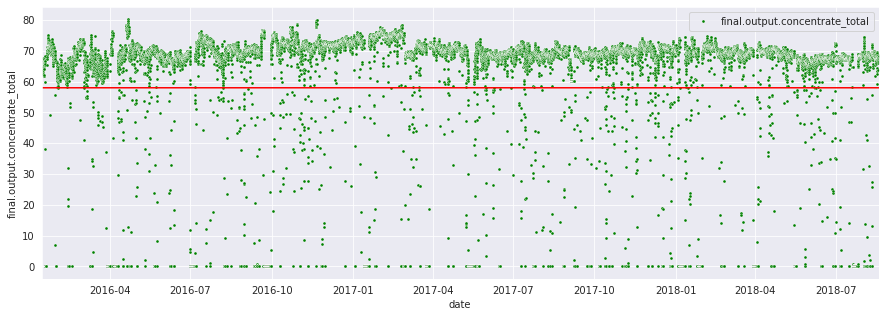

In [72]:
plt.figure(figsize = (15,5))
a = sns.scatterplot(data = gold_recovery_full, x = 'date', y = concentrate_total_all[2],
         marker=".", label = concentrate_total_all[2], linewidth = 0.3, color = 'green')

a = sns.lineplot(data = gold_recovery_full, 
            x = gold_recovery_full['date'],
            y = pd.Series([conc_limit_final for i in range(len(gold_recovery_full))]),
                 color = 'red')

a.set_xlim(gold_recovery_full['date'][0], gold_recovery_full['date'][len(gold_recovery_full)-1])

### 2.3.2 Удаляем аномалии из обучающей выборки  
Поскольку признаки, в которых есть аномалии, отсутствуют в обучающей выборке мы не можем отфильтровать ее напрямую.  Поэтому делаем так:
  - находим те значения "date" в полном датасете gold_recovery_full, при которых происходят аномалии
  - удаляем из обучающей выборки


In [73]:
gold_recovery_full_cleaned = gold_recovery_full[
    (gold_recovery_full['rougher.output.concentrate_total'] > conc_limit_rougher) &
    (gold_recovery_full['primary_cleaner.output.concentrate_total'] > conc_limit_primary_cleaner) &
    (gold_recovery_full['final.output.concentrate_total'] > conc_limit_final)]

Для наглядности отобразим графики без удаленных аномалий

Text(0.5, 1.0, 'Суммарная концентрация на на разных этапах очистки ПОСЛЕ УДАЛЕНИЯ АНОМАЛИЙ')

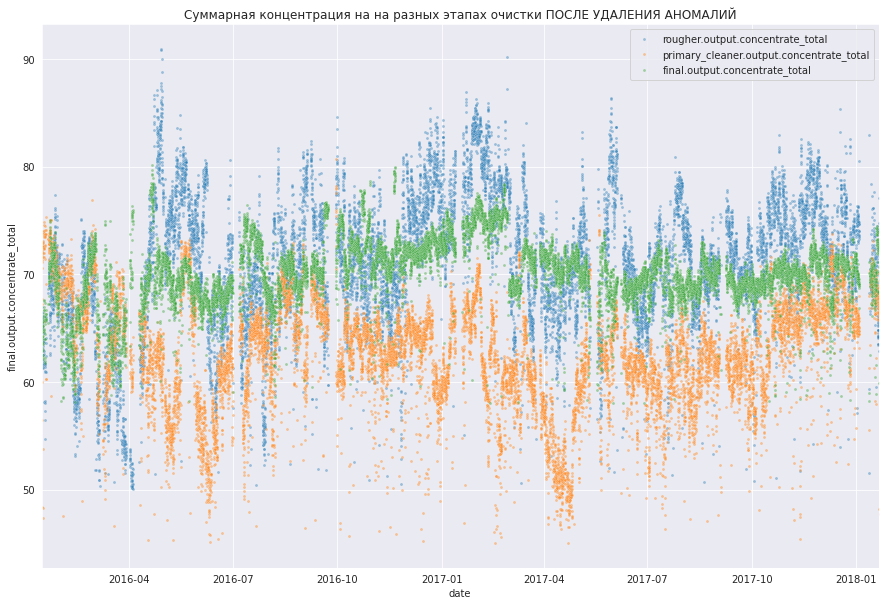

In [74]:
concentrate_total_all = ['rougher.output.concentrate_total', 
                        'primary_cleaner.output.concentrate_total',
                        'final.output.concentrate_total']


plt.figure(figsize=(15,10))

for i in range(len(concentrate_total_all)):
    a = sns.scatterplot(data = gold_recovery_full_cleaned,
         x = 'date', y = concentrate_total_all[i],
         marker=".", alpha=0.4, label=concentrate_total_all[i], linewidth=0.3)
a.set_xlim(gold_recovery_full_cleaned['date'][0], gold_recovery_full_cleaned['date'][len(gold_recovery_full_cleaned)-1])
a.set_title('Суммарная концентрация на на разных этапах очистки ПОСЛЕ УДАЛЕНИЯ АНОМАЛИЙ')  

Посмотрим сколько данных мы отбросили и сколько осталось

In [75]:
print(gold_recovery_full.shape)
print(gold_recovery_full_cleaned.shape)
print('Отбросили {:.2%} данных'.format(
    (gold_recovery_full.shape[0]- gold_recovery_full_cleaned.shape[0])/gold_recovery_full.shape[0]))

(22716, 90)
(17682, 90)
Отбросили 22.16% данных


Отбросили 22.16% данных, но все равно осталась достаточно большая выборка - более 17 тыс  
### 2.3.3 Удаляем аномалии из обучающей выборки  
Принцип удаления: в отфильтрованной выборке gold_recovery_full_clean есть столбец с временем.  В обучающей выборке должны остаться строки только с тем временем, которое есть в gold_recovery_full_clean, все остальные строки - аномалии  
Посмотрим на размеры выборок до удаления:

In [76]:
print(gold_recovery_train.shape)

(13111, 87)


Удаляем аномалии

In [77]:
gold_recovery_train = gold_recovery_train[
                        gold_recovery_train['date'].isin(gold_recovery_full_cleaned['date'])]

Посмотрим на размеры выборок после удаления:

In [78]:
print(gold_recovery_train.shape)

(11661, 87)


Вывод:  
Анализ суммарных концентраций показал наличие аномалий в выборке, которые в последствии мы удалили из рассмотрения. В релуьтате этого   обучающая выборка уменщилась с 13111 до 11661  

# 3.Подбор модели машинного обучения

# Замечание:
1. Метрика качества в данной задаче является функцией от двух целевых признаков. Формула метрики не позволяет объединить 2 целевых признака в один. Поэтому будем строить отдельные модели для каждого из 2 целевых признаков, а потом подставлять данные из этих 2 моделей для расчета основной метрики.
2. В качестве кроссвалидации будем использовать GridSearchCV и для большей точности будем проверять ВСЕ модели на тестовой выборки  
### Напишем функции для вычисления итоговой метрики sMAPE, а также функции для автоматизации обучения и предсказания модели

In [79]:
# функция для расчета промежуточной метрики (по одному из наших целевых признаков)
def SMAPE(y_test, y_predict):
    return (abs(y_test - y_predict) /  \
            ((abs(y_test) + abs(y_predict)) / 2) * 100).sum() / y_test.shape[0]
# функция для расчета финальной метрики 
def SMAPE_total(SMAPE_rougher , SMAPE_final):
    return SMAPE_rougher * 0.25 + SMAPE_final * 0.75

# Задаем нашу собственную функцию sMAPE в качестве метрики при обучении моделей
my_scorer = make_scorer(SMAPE, greater_is_better=True)

In [80]:
# Функция для обучения модели c помощью GridSearchCV и вычисления нужных величин

def model_train(X, y, model):
  # Время начала обучения
  start_time = timeit.default_timer()

  # Обучаем модель
  model.fit(X, y)

  # лучшая модель
  model_best =  model.best_estimator_

  # лучшие гиперпараметры
  model_best_params =  model.best_params_

  # Вычисляем лучшую метрику на кроссвалидации
  SMAPE_train = abs(model.best_score_)

  # Вычисляем время обучения
  fit_time = round(timeit.default_timer() - start_time, 1)

  # Выводим вычисленные величины
  print('Лучшие гиперпараметры:')
  print(model_best_params)
  print('Метрика SMAPE на обучении: {}'.format(round(SMAPE_train,2)))
  print('Время обучения: {:.2} сек'.format(fit_time)) 
  print()

  # возвращаем обученную модель с лучшими ГП,
  # лучшие ГП, метрику, время обучения
  return model.best_estimator_ , model.best_params_, SMAPE_train, fit_time

In [81]:
# Функция для расчета метрики на тестовой выборке 
def model_test(X, y, model_fitted):
  # Время начала расчета
  start_time = timeit.default_timer()
  
  # Считаем метрику на тестовой выборке
  SMAPE_test = SMAPE(y, model_fitted.predict(X))

  # Считаем время предсказания 
  predict_time = round(timeit.default_timer() - start_time, 3)

  # Выводим вычисленные величины
  print('Метрика SMAPE на тестовой выборке: {}'.format(round(SMAPE_test,2)))
  print('Время предсказания: {} сек'.format(predict_time))

  # Возвращаем метрику на тестовой выборке и время предсказания
  return SMAPE_test, predict_time

## 3.1 Подготовка данных.

В тестовой выборке у нас меньше признаков, чем в обучающей.   Для обучения модели кол-во признаков в выборках должно совпадать.  Поэтому удалим и обучающей выборки признаки, которых нет в тестовой   

In [82]:
gold_recovery_train = gold_recovery_train[gold_recovery_test.columns]

Теперь выделим наборы признаков и целевых признаков, с которыми будет работать модель

In [83]:
x_train = gold_recovery_train.drop(
    columns = ['date', 'rougher.output.recovery', 'final.output.recovery'])

y_train_r = gold_recovery_train['rougher.output.recovery']
y_train_f = gold_recovery_train['final.output.recovery']

x_test = gold_recovery_test.drop(
    columns = ['date', 'rougher.output.recovery', 'final.output.recovery'])

y_test_r = gold_recovery_test['rougher.output.recovery']
y_test_f = gold_recovery_test['final.output.recovery']

Делаем стандартизацию признаков (у нас только количественные) 

In [84]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

### 3.2 Подбираем модель для целевого признака rougher.output.recovery (y_train_r / y_test_r)

### 3.2.1 Модель линейная регрессия

Для линейной регрессии нет гиперпараметров для перебора, но используем ее через GridSearchCV, чтобы сохранить единообразие с вычислениями других моделей

In [85]:
# Задаем гиперпараметры
param_grid_LR_r = {'n_jobs': [-1]}

# Задаем модель
model_LR_r = GridSearchCV(estimator = LinearRegression(),
                       param_grid= param_grid_LR_r, cv=3, n_jobs=-1 , scoring = my_scorer)

# Обучаем модель
model_best_LR_r, model_params_LR_r, SMAPE_train_LR_r, fit_time_LR_r = model_train(x_train_st, y_train_r, model_LR_r)

# Считаем метрику на тестовой выборке
SMAPE_test_LR_r, predict_time_LR_r =  model_test(x_test_st, y_test_r, model_best_LR_r)

Лучшие гиперпараметры:
{'n_jobs': -1}
Метрика SMAPE на обучении: 104.06
Время обучения: 1.8 сек

Метрика SMAPE на тестовой выборке: 112.94
Время предсказания: 0.003 сек


#### 3.2.2 Модель LightGBM

In [86]:
# Задаем гиперпараметры
param_grid_LGBM_r = {'num_leaves': [i*10 for i in range(1,15)],
                 'max_depth': [-1, 1, 2, 3, 5, 6, 7, 8, 9, 10, 15, 20],
                 'n_estimators' : [25],
                  'min_data_in_leaf': [i*10 for i in range(1,10, 2)] + [i*100 for i in range(1,10,2)] + [i*1000 for i in range(1,10,2)]}
# сразу подставляем лушие параметры
param_grid_LGBM_r = {'max_depth': [25],     2
                   'min_data_in_leaf': [15],   1000
                    'n_estimators' : [10],   50
                    'num_leaves': [100]}     5

# Задаем модель
model_LGBM_r = GridSearchCV(estimator = LGBMRegressor(), 
             param_grid=  {'random_state' : [42]},
              cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель
model_best_LGBM_r, model_params_LGBM_r, SMAPE_train_LGBM_r, fit_time_LGBM_r = model_train(x_train_st, y_train_r, model_LGBM_r)

# Считаем метрику на тестовой выборке
SMAPE_test_LGBM_r, predict_time_LGBM_r =  model_test(x_test_st, y_test_r, model_best_LGBM_r)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


Лучшие гиперпараметры:
{'random_state': 42}
Метрика SMAPE на обучении: 11.22
Время обучения: 5.8 сек

Метрика SMAPE на тестовой выборке: 10.68
Время предсказания: 0.027 сек


### 2.2.3 Модель Catboost

In [87]:
# Задаем гиперпараметры
param_grid_Cat_r = {'iterations': [10, 50],
                'depth': [1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 18]}
# сразу подставляем лушие параметры
param_grid_Cat_r = {'iterations': [30],
                  'depth': [7]}

# Задаем модель
model_Cat_r = GridSearchCV(
    estimator = CatBoostRegressor(),
    param_grid = {'random_state' : [42]}, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)   

# Обучаем модель
model_best_Cat_r, model_params_Cat_r, SMAPE_train_Cat_r, fit_time_Cat_r = model_train(x_train_st, y_train_r, model_Cat_r)

# Считаем метрику на тестовой выборке
SMAPE_test_Cat_r, predict_time_Cat_r =  model_test(x_test_st, y_test_r, model_best_Cat_r)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.6s finished


Learning rate set to 0.060434
0:	learn: 550.9120880	total: 75.9ms	remaining: 1m 15s
1:	learn: 534.5821614	total: 94ms	remaining: 46.9s
2:	learn: 520.0367024	total: 112ms	remaining: 37.2s
3:	learn: 499.6698863	total: 130ms	remaining: 32.5s
4:	learn: 481.5664032	total: 150ms	remaining: 29.8s
5:	learn: 467.2995192	total: 170ms	remaining: 28.2s
6:	learn: 453.5004671	total: 189ms	remaining: 26.9s
7:	learn: 441.2145993	total: 211ms	remaining: 26.1s
8:	learn: 428.1624693	total: 229ms	remaining: 25.2s
9:	learn: 415.5735090	total: 246ms	remaining: 24.3s
10:	learn: 402.1695499	total: 263ms	remaining: 23.7s
11:	learn: 390.3092546	total: 281ms	remaining: 23.1s
12:	learn: 376.1615771	total: 304ms	remaining: 23.1s
13:	learn: 365.0746603	total: 321ms	remaining: 22.6s
14:	learn: 355.2248172	total: 339ms	remaining: 22.3s
15:	learn: 342.3766100	total: 357ms	remaining: 21.9s
16:	learn: 332.1905620	total: 375ms	remaining: 21.7s
17:	learn: 322.3690463	total: 393ms	remaining: 21.5s
18:	learn: 310.7100141	to

### 3.2.4 Модель SVR

In [88]:
# Задаем гиперпараметры
param_grid_SVR_r = {'C': [0.0001 ,0.0005, 0.001 , 0.005, 0.01, 0.05], 'gamma': [5, 10, 15, 25, 50, 75]}
# Сразу подставляем лучшие парметры, чтобы быстрее считал:
param_grid_SVR_r = {'C': [0.005], 'gamma': [25]}

# Задаем модель
model_SVR_r = GridSearchCV(estimator=SVR(), 
                param_grid= param_grid_SVR_r, scoring = my_scorer, cv=3, verbose=1, n_jobs= -1)

# Обучаем модель
model_best_SVR_r, model_params_SVR_r, SMAPE_train_SVR_r, fit_time_SVR_r = model_train(x_train_st, y_train_r, model_SVR_r)

# Считаем метрику на тестовой выборке
SMAPE_test_SVR_r, predict_time_SVR_r =  model_test(x_test_st, y_test_r, model_best_SVR_r)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s finished


Лучшие гиперпараметры:
{'C': 0.005, 'gamma': 25}
Метрика SMAPE на обучении: 8.55
Время обучения: 3.9e+01 сек

Метрика SMAPE на тестовой выборке: 8.59
Время предсказания: 5.191 сек


#### 3.2.5 Выбор лучшей модели

In [91]:
# Занесем результаты в таблицу
list_models = ['linear_regression', 'LGBM', 'Catboost',  'SVR']
list_train_scores_r = [SMAPE_train_LR_r, SMAPE_train_LGBM_r, 
                 SMAPE_train_Cat_r, SMAPE_train_SVR_r]

list_fit_time_r = [fit_time_LR_r, fit_time_LGBM_r, 
                   fit_time_Cat_r, fit_time_SVR_r]

list_test_scores_r = [SMAPE_test_LR_r, SMAPE_test_LGBM_r, 
                 SMAPE_test_Cat_r, SMAPE_test_SVR_r]

list_predict_time_r = [predict_time_LR_r, predict_time_LGBM_r, 
                   predict_time_Cat_r, predict_time_SVR_r]

model_scores_r = pd.DataFrame(
    {'model': list_models, 
     'SMAPE_rougher_train': list_train_scores_r,
     'fit_time': list_fit_time_r,
     'SMAPE_rougher_test': list_test_scores_r,
     'predict_time': list_predict_time_r,
     })
model_scores_r

,model,SMAPE_rougher_train,fit_time,SMAPE_rougher_test,predict_time
0,linear_regression,104.059839,1.8,112.943190,0.003
1,LGBM,11.217890,5.8,10.675106,0.027
2,Catboost,8.191092,73.4,8.093361,0.012
3,SVR,8.550967,39.3,8.589519,5.191


In [92]:
# сохраняем значение лучшей метрики
sMAPE_rougher_test = model_scores_r['SMAPE_rougher_train'].abs().min()
sMAPE_rougher_test

8.191091743268599

Выводы:
1. Лучший результат на обучении показал Catboost. На тесте он также показывает лучший результат.
2. Линейная регрессия дает неадекватные результаты
2. Из адекватных моделей лучшая скорость у LGBM  
3. Выбираем модель Catboost


In [93]:
# сохраняем для выбранной модели значение метрики на ТЕСТОВОЙ выборке (для расчета финальной метрики в конце)
SMAPE_rougher_test = model_scores_r[
                            model_scores_r['SMAPE_rougher_train'] == model_scores_r['SMAPE_rougher_train'].min()] ['SMAPE_rougher_test'].values[0]
SMAPE_rougher_test

8.093360898165532

### 3.2.3 Подбираем модель для второго целевого признака final.output.recovery (y_train_f / y_test_f)

#### 3.2.3.1 Модель линейная регрессия

In [94]:
# Задаем гиперпараметры
param_grid_LR_f = {'n_jobs': [-1]}

# Задаем модель
model_LR_f = GridSearchCV(estimator = LinearRegression(),
                       param_grid= param_grid_LR_f, cv=3, n_jobs=-1 , scoring = my_scorer)

# Обучаем модель
model_best_LR_f, model_params_LR_f, SMAPE_train_LR_f, fit_time_LR_f = model_train(x_train_st, y_train_f, model_LR_f)

# Считаем метрику на тестовой выборке
SMAPE_test_LR_f, predict_time_LR_f =  model_test(x_test_st, y_test_f, model_best_LR_f)

Лучшие гиперпараметры:
{'n_jobs': -1}
Метрика SMAPE на обучении: 12.56
Время обучения: 0.7 сек

Метрика SMAPE на тестовой выборке: 9.26
Время предсказания: 0.003 сек


#### 3.2.3.2 Модель LightGBM

In [95]:
# Задаем гиперпараметры
param_grid_LGBM_f = {'num_leaves': [i*10 for i in range(1,15)],
                 'max_depth': [-1, 1, 2, 3, 5, 6, 7, 8, 9, 10, 15, 20],
                 'n_estimators' : [25],
                  'min_data_in_leaf': [i*10 for i in range(1,10, 2)] + [i*100 for i in range(1,10,2)] + [i*1000 for i in range(1,10,2)]}
# сразу подставляем лушие параметры
param_grid_LGBM_f = {'max_depth': [25],     2
                    'min_data_in_leaf': [15],   1000
                  'n_estimators' : [10],   50
                    'num_leaves': [100]}     5

# Задаем модель
model_LGBM_f = GridSearchCV(estimator = LGBMRegressor(), 
             param_grid= {'random_state' : [42]} ,
              cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)

# Обучаем модель
model_best_LGBM_f, model_params_LGBM_f, SMAPE_train_LGBM_f, fit_time_LGBM_f = model_train(x_train_st, y_train_f, model_LGBM_f)

# Считаем метрику на тестовой выборке
SMAPE_test_LGBM_f, predict_time_LGBM_f =  model_test(x_test_st, y_test_f, model_best_LGBM_f)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


Лучшие гиперпараметры:
{'random_state': 42}
Метрика SMAPE на обучении: 10.73
Время обучения: 5.7 сек

Метрика SMAPE на тестовой выборке: 9.79
Время предсказания: 0.025 сек


#### 2.2.3.3 Модель Catboost

In [96]:
# Задаем гиперпараметры
param_grid_Cat_f = {'iterations': [10, 50],
                'depth': [1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 18]}
# сразу подставляем лушие параметры
 aram_grid_Cat_f = {'iterations': [30],
                  'depth': [7]}

# Задаем модель
model_Cat_f = GridSearchCV(
    estimator = CatBoostRegressor(),
    param_grid = {'random_state' : [42]}, cv=3, verbose=1, n_jobs=-1, scoring = my_scorer)   

# Обучаем модель
model_best_Cat_f, model_params_Cat_f, SMAPE_train_Cat_f, fit_time_Cat_f = model_train(x_train_st, y_train_f, model_Cat_f)

# Считаем метрику на тестовой выборке
SMAPE_test_Cat_f, predict_time_Cat_f =  model_test(x_test_st, y_test_f, model_best_Cat_f)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.8s finished


Learning rate set to 0.060434
0:	learn: 7.9022613	total: 20.4ms	remaining: 20.4s
1:	learn: 7.7594391	total: 44.9ms	remaining: 22.4s
2:	learn: 7.6244873	total: 64.2ms	remaining: 21.3s
3:	learn: 7.4954713	total: 84.1ms	remaining: 20.9s
4:	learn: 7.3802823	total: 104ms	remaining: 20.6s
5:	learn: 7.2711517	total: 123ms	remaining: 20.4s
6:	learn: 7.1662849	total: 141ms	remaining: 20.1s
7:	learn: 7.0753454	total: 160ms	remaining: 19.8s
8:	learn: 6.9874056	total: 177ms	remaining: 19.5s
9:	learn: 6.9036833	total: 198ms	remaining: 19.6s
10:	learn: 6.8306677	total: 217ms	remaining: 19.5s
11:	learn: 6.7565171	total: 236ms	remaining: 19.4s
12:	learn: 6.6930546	total: 254ms	remaining: 19.3s
13:	learn: 6.6376977	total: 272ms	remaining: 19.2s
14:	learn: 6.5780511	total: 290ms	remaining: 19s
15:	learn: 6.5381619	total: 308ms	remaining: 18.9s
16:	learn: 6.4863572	total: 327ms	remaining: 18.9s
17:	learn: 6.4317911	total: 345ms	remaining: 18.8s
18:	learn: 6.3881362	total: 363ms	remaining: 18.8s
19:	learn

#### 3.2.2.4 Модель SVR

In [97]:
# Задаем гиперпараметры
param_grid_SVR_f = {'C': [0.0001 ,0.0005 ,0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'gamma': [5, 10, 15, 20, 25, 50, 75, 100]}
# Сразу подставляем лучшие парметры, чтобы быстрее считал:
param_grid_SVR_f = {'C': [0.001], 'gamma': [100]}

# Задаем модель
model_SVR_f = GridSearchCV(estimator=SVR(), 
                param_grid= param_grid_SVR_f, scoring = my_scorer, cv=3, verbose=1, n_jobs= -1)

# Обучаем модель
model_best_SVR_f, model_params_SVR_f, SMAPE_train_SVR_f, fit_time_SVR_f = model_train(x_train_st, y_train_f, model_SVR_f)

# Считаем метрику на тестовой выборке
SMAPE_test_SVR_f, predict_time_SVR_f =  model_test(x_test_st, y_test_f, model_best_SVR_f)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.2s finished


Лучшие гиперпараметры:
{'C': 0.001, 'gamma': 100}
Метрика SMAPE на обучении: 9.75
Время обучения: 3.8e+01 сек

Метрика SMAPE на тестовой выборке: 9.69
Время предсказания: 5.034 сек


#### 3.2.2.5 Выбор лучшей модели

Выведем метрики для каждой модели

In [98]:
list_models = ['linear_regression', 'LGBM', 'Catboost',  'SVR']
list_fit_scores_f = [SMAPE_train_LR_f, SMAPE_train_LGBM_f, 
                 SMAPE_train_Cat_f, SMAPE_train_SVR_f]

list_train_time_f = [fit_time_LR_f, fit_time_LGBM_f, 
                   fit_time_Cat_f, fit_time_SVR_f]

list_test_scores_f = [SMAPE_test_LR_f, SMAPE_test_LGBM_f, 
                 SMAPE_test_Cat_f, SMAPE_test_SVR_f]

list_predict_time_f = [predict_time_LR_f, predict_time_LGBM_f, 
                   predict_time_Cat_f, predict_time_SVR_f]

model_scores_f = pd.DataFrame(
    {'model': list_models, 
     'SMAPE_final_output_train': list_fit_scores_f,
     'fit_time': list_train_time_f,
     'SMAPE_final_output_test': list_test_scores_f,
     'predict_time': list_predict_time_f,
     })
model_scores_f

,model,SMAPE_final_output_train,fit_time,SMAPE_final_output_test,predict_time
0,linear_regression,12.558054,0.7,9.257646,0.003
1,LGBM,10.733266,5.7,9.787414,0.025
2,Catboost,10.692155,72.1,9.999516,0.012
3,SVR,9.750703,38.1,9.688893,5.034


In [99]:
# сохраняем значение лучшей метрики
SMAPE_final_test = model_scores_f[
                            model_scores_f['SMAPE_final_output_train'] == model_scores_f['SMAPE_final_output_train'].min()] ['SMAPE_final_output_test'].values[0]
SMAPE_final_test

9.688893007064058

Выводы:
1. Лучший результат на обучении показал SVR. На тесте он также показывает хороший результат (его немного опережает Catboost).
2. По времени лучшие результаты у LGBM  
3. Очень хороший результат показала обыкновенная линейная регрессия, на тесте она дает лучший результат
4. Выбираем для дальнейшей работы модель SVR

### 3.2.4 Вычисляем окончательную суммарную метрику sMAPE_total

 Вычисляем итоговый sMAPE

In [100]:
SMAPE_total_test = SMAPE_total(SMAPE_rougher_test , SMAPE_final_test)
SMAPE_total_test

9.290009979839425

Еще раз покажем лучшие значения промежуточных SMAPE

In [101]:
display(SMAPE_rougher_test)
display(SMAPE_final_test)

8.093360898165532

9.688893007064058

sMAPE является аналогом средней абсолютной ошибки. Поэтому можем оценить погрешность наших моделей как отношение этой ошибки к средним значениям целевых признаков: 

In [102]:
display( SMAPE_rougher_test / pd.concat([y_train_r, y_test_r]).mean())
display(SMAPE_final_test / pd.concat([y_train_f, y_test_f]).mean())

0.10651541208060919

0.14338063896886977

## Общий вывод:
1. В датасете имеются пропуски.  Часть пропусков удалили, а часть пропусков заполнили с помощью:
    - аналитической формулы из условия задачи;
    - линейной регрессии на коррелирующих признаках;
    - методом "ffill".
2. В датасете есть выбросы - нулевые значения.  
3. Целевая метрика = функция от 2 целевых признаков => подбирались 2 отдельные модели на каждый из 2 признаков. Итоговая метрика на тестовой выборке = 9.28. Погрешность 10-14% при оценке спрогнозированных целевых признаков  
4. Для обоих признаков лучшие результаты у модели SVR. 
5. Для второго целевого признака неожиданно хороший результат показала простая линейная регрессия.
   